This notebook aims to create extract key words from lithology descriptions. The notebook will work on building a dictionary for key geological and textural words. This is done by a combination of defining synonymous words explicitly (e.g. gravel and pebbles) and fuzzy string matching to pickup spelling errors and shorthand (e.g. s/stn vs sandstone). For now we are focussing on single words but future endeavors will work on sequences of consecutive words (i.e. well-rounded, red-brown)

One a significant portion of words within the lithology logs are standardised we will attempt an automatic classification of intervals into a set number of key lithologies using a bag of words approach

Neil Symington
neil.symington@ga.gov.au

In [1]:
import pandas as pd
import json
import numpy as np
import re
from collections import Counter
from fuzzywuzzy import process
import time
import matplotlib.pyplot as plt

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Define key functions

def add_to_dictionary(value, key, dictionary):
    """
    A function for appending an object to a dictionary
    entry
    
    @param value: object to be added to the dictionary
    @param key: dictionary key
    @dictionary: dictionary
    returns
    dictionary with added values
    """
    # Check if it already exists if so add nothing
    try:
        if values in dictionary[key]:
            return dictionary
        # Otherwise add the word
        else:
            dictionary[key] += [values]
            return dictionary
    except KeyError:
        dictionary[key] = [values]
        return dictionary

def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

def findUnregisteredWords(kword_dict, lithDescription):
    """
    A function for searching through a sequence of 
    lithology desciptions, removing punctuation and cases
    and then returning all the words that are not contained
    as values within the entries of a key word dictoinary
    
    @param kword_dict: key-word dictionary
    @param lithDescription: sequence of strings describing
    borehole lithology
    
    returns
    list of unregstered words
    
    """
    # Create list into which unregistered words will be appended
    unregistered_words = []
    # Iterate through lithology descriptions
    for item in lithDescription:
        # This is to prevent errors if there are None elements
        # in the list
        if item is not None:
        # remove punctuation and split into list
            L = re.sub(r'[^\w\s]','', item).split()
            # iterte through word list
            for word in L:
                # If the word does not exist yet in dictionary
                # Append it to the list
                if search(kword_dict, word) is None:
                    
                    unregistered_words.append(word.lower())
    return unregistered_words

def bag_of_words(string, kwords):
    """
    Function for counting the occurene of key words
    within a lithology description
    
    @param string: string from which to search for keywords
    @parma kwords: dictionary of keywords where the key is the
    keyword and the entries are a list of 'synonyms'
    returns
    
    dictionary with score denoting the number of times a
    key word was seen
    """
    # remove punctuation and split into list
    L = re.sub(r'[^\w\s]','', string).split()
    # mak entirely lowercase
    L = [x.lower() for x in L]
    
    newDict = {}
    # Iterate through kewords
    for item in kwords:
        # Assign the keyword a zero meaning unseen
        # This will be updated if the word is 
        # found in the lithology description
        newDict[item] = 0
        # ITerate through mapped words
        for entry in kwords[item]:
            # if the entry is in the string
            # assign the item a 1 in newDict
            if entry in L:
                newDict[item] += 1
    
    # Return the dictionary
    return newDict

In [ ]:
# Create a dicitonary with a set of keywords for interpreting drilling log lithology and texture descriptions

lithology_kwords = {}

kword_file = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\ngis_borehole_keyword_search.csv"

df_keywords = pd.read_csv(kword_file)

for index, row in df_keywords.iterrows():
    kword = row['key_words']
    lithology_kwords[kword] = [kword]

print(lithology_kwords)

In [ ]:
# Now we open some of the examples already given to us by Christian
# and add them to the dictionary

infile = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\LithologyLookupTable.csv"

df_kwords_lookup = pd.read_csv(infile)


for index, row in df_kwords_lookup.iterrows():
    # Extract words and make lowercase
    kword = row['Lithology Simplified'].lower()
    ngis_word = row['NGIS Logged Lithology'].lower()
    # If the kword is in the dictionary keys then add the 
    # ngis word to the list if it doesn't exist
    if kword in lithology_kwords.keys():
        if ngis_word not in lithology_kwords[kword]:
            lithology_kwords[kword].append(ngis_word)
            
lithology_kwords



In [3]:
# Now open the Bonaparte DAFWA bores where some interpretation has already been done

infile = r"C:\GA\boreholes\NT_WA_KeepRiver_OrdBon_WeaberPlain_bores_strater_mastersheet.xlsx"

df_bon = pd.read_excel(infile, sheet_name ="Lithology")

# For now we will drop nulls

df_bon=df_bon[~df_bon['LITHOLOGY_1'].isnull()]

In [4]:
# Import the drillers logs from EK

infile = r"C:\GA\boreholes\lithologies_scraped.csv"

df_ek = pd.read_csv(infile)

df_ek.drop(columns =['Unnamed: 0'], inplace=True)

# Remmove duplicate entries

df_ek = df_ek.drop_duplicates()

# For now we will drop nulls

df_ek=df_ek[~df_ek['Lithology'].isnull()]

In [5]:
# Now scrapte the NGIS database for additional lithologies

# This database is a copy of key tables for boreholes in the NGIS
# database that fall within the EFtF project areas
db = r"C:\GA\boreholes\Borehole_Data_Consolidation_CompositeLogs_NeilFork\EFTF_BH.sqlite"

import sqlite3

conn = sqlite3.connect(db)

# open the lithologies table using a sql qury in pandas
query = 'SELECT * from Lithology;'
df_ngis = pd.read_sql(query, conn)


In [95]:
# List unregistered words
unregistered_words = []

unregistered_words += findUnregisteredWords(lithology_kwords,
                                            df_bon['LITHOLOGY_1'].unique())
unregistered_words += findUnregisteredWords(lithology_kwords,
                                            df_ek['Lithology'].unique())

unregistered_words += findUnregisteredWords(lithology_kwords,
                                            df_ngis['l_Description'].unique())


In [96]:
# Create a counter to help us visualise the most common words 
cnt = Counter()
for word in unregistered_words:
    cnt[word]+=1

# Visualise the top 1000 words
cnt.most_common(1000)

[('above', 203),
 ('micaceous', 200),
 ('fragments', 191),
 ('strength', 158),
 ('chips', 149),
 ('from', 148),
 ('highly', 141),
 ('seams', 135),
 ('loose', 134),
 ('stiff', 127),
 ('interbedded', 125),
 ('struck', 121),
 ('large', 114),
 ('20', 112),
 ('peds', 112),
 ('becoming', 108),
 ('forming', 108),
 ('fracturing', 108),
 ('but', 95),
 ('flecks', 93),
 ('consisting', 89),
 ('rare', 86),
 ('drilling', 86),
 ('mixed', 85),
 ('bearing', 83),
 ('gned', 81),
 ('vesicular', 80),
 ('depth', 73),
 ('sphericity', 72),
 ('full', 69),
 ('metres', 68),
 ('multicoloured', 68),
 ('ferruginous', 64),
 ('soak', 60),
 ('thixotropic', 59),
 ('colours', 57),
 ('little', 56),
 ('mainly', 55),
 ('strata', 54),
 ('bottom', 53),
 ('abundant', 52),
 ('cobbles', 51),
 ('1cm', 51),
 ('whitish', 49),
 ('quality', 48),
 ('weathering', 48),
 ('oxidised', 47),
 ('drydamp', 46),
 ('porous', 44),
 ('shingle', 44),
 ('gns', 44),
 ('descripconduct', 43),
 ('swelling', 43),
 ('staining', 43),
 ('mineralisation', 

In [101]:
cnt['some']

0

In [ ]:
# Here we go through the unregistered words and 
# do a fuzzy string match with keywords in the dictionary

# iterate through all words -- this may take a while
for item in unregistered_words:
    # Find the five closest string matchs
    result = process.extract(item, lithology_kwords.keys(), limit=5)
    # Iterate through these string matches
    for i in range(len(result)):
        # If the 'score' is between 100 and 85 then it is considered
        # a match
        if result[i][1] >=85.:
            # append to the dataframe 
            lithology_kwords[result[i][0]].append(item)
            
# Remove duplicates

for item in lithology_kwords.keys():
    lithology_kwords[item] = list(set(lithology_kwords[item]))

In [94]:
# Open the key word dictionary from a json file or save as a json file


filename = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\NGIS_lithology_kwords_fuzzy.json"

#with open(filename, 'r') as f:
#    lithology_kwords = json.load(f)

with open(filename, 'w') as f:
    # Make sure the dictionary exists otherwise the json will be wiped
    try:
        lithology_kwords
    except NameError:
        print("Dictionary undefined")
    else:
        json.dump(lithology_kwords, f,
                  indent=4, sort_keys=True)

Next is a manual step of removing incorrect entries. A commmon error is for a match between two words that are similar but there are actually separate classes for each. For example "pinksiltstone" matches 'silt' incorrectly when it should match siltstone. Furthermore there are some spurious results like 'clay' for 'noclay' or just some errors "red" matching with "weathered".

All in all the editting job is best done with a human eye on the json file within a text editor

In [7]:
# To save the edits we make we will reimport the file and find the differences and save them into dictionaries

#filename = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\NGIS_lithology_kwords.json"

with open(filename, 'r') as f:
    lithology_kwords_modified = json.load(f)

    
deleted_entries = {}
added_entries = {}

for item in lithology_kwords:
    deleted_entries[item] = []
    added_entries[item] = []
    
    try:
        for entry in lithology_kwords[item]:
            if entry not in lithology_kwords_modified[item]:
                deleted_entries[item].append(entry)
    except KeyError:
        pass
    
for item in lithology_kwords_modified:
    try:
        for entry in lithology_kwords_modified[item]:
            if entry not in lithology_kwords[item]:
                added_entries[item].append(entry)
    except KeyError:
        added_entries[item] = []

In [ ]:
# Save changes dictionaries as a json file

dict_changes = {'added_entries': added_entries,
                'deleted_entries': deleted_entries}

filename = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\lithology_kwords_manual_edits.json"

#with open(filename, 'w') as f:
#    json.dump(dict_changes, f, indent=4)



In [15]:
# To redo the editting using the saved changes run this cell

# Open the manual edits
filename = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\lithology_kwords_manual_edits.json"

with open(filename, 'r') as f:
    dict_changes = json.load(f)

added_entries = dict_changes['added_entries']
deleted_entries = dict_changes['deleted_entries']


for item in [x for x in deleted_entries if x in lithology_kwords.keys()]:
    if len(deleted_entries[item]) != 0:
        for entry in deleted_entries[item]:
            try:
                lithology_kwords[item].remove(entry)
            except ValueError:
                pass

for item in added_entries:
    try:
        if len(added_entries[item]) != 0:
            for entry in added_entries[item]:
                if entry not in lithology_kwords[item]: 
                    lithology_kwords[item].append(entry)
    except ValueError:
        lithology_kwords[item] = added_entries[item]           

In [16]:
# Here is an example of how this data could be used to create a bag of words for an ngis bore

# First we select a bore from within the Ord-Keep project area - uid extracted from GIS


df_ek_lith = df_ngis[df_ngis['uid'] == 2869]['l_Description']
print(df_ek_lith)

18597    Sand: f - med gn; loose; clear - wh gns; loose...
18598    50% sand: f gned; milky to clear gns; poorly s...
18599                                  Clay: plastic clay.
18600                                  Clay: plastic clay.
18601                Clay: red bwn; pebbles of rock frags.
18602    Sand: med gned; some pebble; red bwn soft clay...
18603    Gravel: red bwn; 60% rock frag; rock frags; ve...
18604    50% sand: v fgn with clay matrix - red with qu...
18605    50% sand: v fgn with clay matrix - red with qu...
18606    Sand: med gn; loose; orange col; subrded; poor...
18607    Sand: f - med gn; milky wh to or - wh; qtz gn;...
18608    Sand: f - med gn; milky wh to or - wh; qtz gn;...
Name: l_Description, dtype: object


In [17]:
# We will create a dataframe to display the results

df_results = pd.DataFrame(columns = lithology_kwords.keys())

# Iterate through the panda series
for index, string in df_ek_lith.items():
    # Get a dictionary with the word count for each keyword
    newDict = bag_of_words(string, lithology_kwords)
    # Append this to a dataframe with the same index as
    # the original data
    df_results = df_results.append(pd.DataFrame(newDict,
                                   index = [index]))

In [18]:
# We will display the results for the four most important
# sediment types
df_results[['sand','clay', 'gravel', 'silt']]

sand clay gravel silt
18597    1    1      0    0
18598    1    1      0    0
18599    0    1      0    0
18600    0    1      0    0
18601    0    1      1    0
18602    1    1      1    0
18603    0    0      1    0
18604    1    1      1    0
18605    1    1      1    0
18606    1    0      0    0
18607    1    1      0    0
18608    1    1      0    0

In [23]:
# Now we will try the whole NGIS database. This takes some time

df_results = pd.DataFrame(columns = lithology_kwords.keys())

# Iterate through the panda series
for index, string in df_ngis['l_Description'].dropna().items():
    # Get a dictionary with the word count for each keyword
    newDict = bag_of_words(string, lithology_kwords)
    # Append this to a dataframe with the same index as
    # the original data
    df_results = df_results.append(pd.DataFrame(newDict,
                                   index = [index]))

In [39]:
df_ngis[['l_Description','uid']].dropna()

l_Description    uid
0                       Gravel & sand  - water   1328
1            Quality descrip/conduct: suitable   1328
2          Grey sandstone - water struck  rose   1328
3                                  Brown shale   1328
4                                   Water sand   1328
5          Grey sandstone - water struck  rose   1328
6                                 Water gravel   1328
7           Grey sandstone - water struck (did   1328
8                                   Grey shale   1328
9                             Yellow sandstone   1328
10                                  Black soil   1328
11                             Black sandstone   1329
12           Quality descrip/conduct: brackish   1329
13              Quality descrip/conduct: salty   1329
14            Quality descrip/conduct: potable   1329
15                                   Sandstone   1329
16                                        Clay   1329
17                                   Sandstone   1329
18                                 Sandy shale   1329
19                         Water sand - (soak)   1329
20                                   Sandstone   1329
21                         Water bed  - (soak)   1329
22                                   Sandstone   1329
23                         Brown & white shale   1329
24                         Water bed  - (soak)   1329
25                                   Sandstone   1329
26                                 Sandy shale   1329
27                  Water bed  - water bearing   1329
28                          Sand and soft clay   1338
29                                  Stiff clay   1338
...                                        ...    ...
79665                                    Silty   9046
79668                       & Dolomite Gravels   3817
79669                            & Yellow Sand   3817
79670                                Dolomitic   3369
79671                               Grey/black   3798
79672                                    Black   3798
79673           with bands of Quartz Sandstone  13024
79674                                      Red   3472
79675                                   & Clay   3450
79676                             Hard dry red   3463
79677                       Broken ground Sand   3740
79678                                  Topsoil   3771
79680                            Orange Coffee   3816
79681                                     Blue   3806
79682                         Red & Blue Bands   3806
79683                                      Red   3807
79684                 Yellow & White Sandstone   3753
79685             Fractured bands every 1-1.5m   3753
79686                         & Quartz Gravels   3775
79687                               Fresh blue   3492
79688                                & Gravels   3317
79690                                    Brown   3318
79691                                Fractured   3318
79692        Brown & Grey minor, Iron & Quartz   3744
79693  Broken brown & grey minor Iron & Quartz   3744
79694                                     Grey   8635
79695                                   Yellow   3786
79696                                      Red   3760
79697                          Tan, Minor Clay   3760
79698                                     Grey   3489

[69501 rows x 2 columns]

In [50]:
# WE will add this bag of word to the database as a separate table

df_export = pd.merge(df_results,df_ngis[['l_Description','uid']].dropna(),
                           left_index = True, right_index=True).drop_duplicates()


In [52]:
#Export it the the database
df_export.to_sql('lith_bag_of_words', conn, if_exists= 'replace', index=False,
                chunksize=100)

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\generic.py:2127: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


In [57]:
# Visualise the relative proportion of clay
# sand, silt and gravel


def sum_pie_plot(df, columns):
    """
    @parameter df: dataframe of bag of words
    @parameter columns: columns to plot
    
    """
    plt.close()
    df[columns].sum().plot(kind='pie')
    plt.axis('equal')
    plt.title('Relative proportion of keywords')
    plt.show()
    

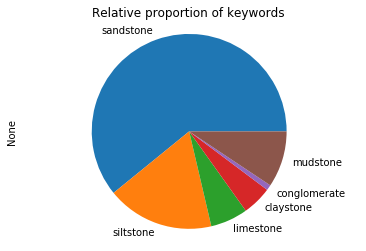

In [60]:
sum_pie_plot(df_results, ['sandstone', 'siltstone', 'limestone', 'claystone', 'conglomerate', 'mudstone'])

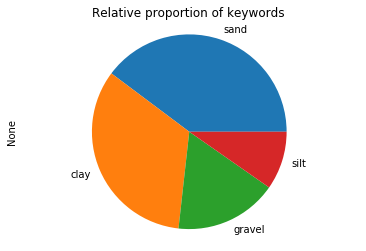

In [61]:
sum_pie_plot(df_results, ['sand','clay', 'gravel', 'silt'])

In [63]:
df_results['sand'].unique()

array([1, 0, 2, 4, 3], dtype=object)

In [64]:
df_ngis[['l_Description','uid']].sample(20)

l_Description    uid
56764                                                Red  16164
33424                                      STICKY SNOTTY   4601
25228                                  DENSE CLAYEY/SAND   4329
19820                                     GREY AND WHITE  12523
7557                                     Sandy clay grey    736
39993                                               None  11242
32412                                               PINK  13333
58084                                       brown, sandy  14751
58938                                               None   9864
18856                                               None  14365
65208                                         & dolomite   6742
57202                                             & clay  15428
37793                                 Brown white yellow  17340
23322                                       AND LATERITE  17285
10005                                        Brown shale   1772
54241                                               None  15942
2720   Sand, fine to medium, well graded, subangular,...   1252
61473                                 Red, white, yellow   6490
32899                                   BROWN (FRACTURE)   8109
74115                           Red & material, gravelly  13822